## Kaggle dataset TFIDF

In [21]:
# load package
import nltk
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
#display(data)

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
#
import scikitplot.plotters as skplt
import scikitplot.plotters as skplt
import nltk
from xgboost import XGBClassifier




### TDIDF

In [23]:
# load data
df_train3 = pd.read_csv('../data/context/df_train_context.csv') # change to your local files
df_test3 = pd.read_csv('../data/context/df_test_context.csv')
print(df_train3.shape)
print(df_test3.shape)

(3297, 6)
(5668, 5)


In [25]:
df_train3.head()

,Unnamed: 0,ID,Gene,Variation,Class,new_context
0,0,0,FAM58A,Truncating Mutations,1,"way, which confers tamoxifen resistance to bre..."
1,1,1,CBL,W802*,2,ptor molecule important in normal homeostasis ...
2,2,2,CBL,Q249E,2,ptor molecule important in normal homeostasis ...
3,3,3,CBL,N454D,3,ovel mechanism by which pathogenetic mutations...
4,4,4,CBL,L399V,4,ht underlying how stability-activity tradeoffs...


In [26]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
from sklearn.model_selection import train_test_split
df_train3, _ = train_test_split(df_train3, test_size=0.7, random_state=8, stratify=df_train3['Class'])
df_train3.shape

(989, 6)

In [27]:
# vectorizatioin
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = tfidf_vectorizer.fit_transform(df_train3.ix[:,-1])

In [28]:
tfidf.shape

(989, 60040)

In [29]:
# SVD dimension reduce
svd = TruncatedSVD(n_components=100, n_iter=100, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

# assign 
X = truncated_tfidf
#X = tfidf
y = df_train3['Class'].values.ravel()


In [30]:
truncated_tfidf.shape

(989, 100)

In [31]:
def evaluate_features(X, y, clf=None, ):
    if clf is None:
        clf = LogisticRegression()
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)
    
    

def gs_clf(clf, X, y, **param_grid):
    clf = GridSearchCV(clf, param_grid)
    clf.fit(X,y)
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)

    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    print(clf.best_params_)
    

### GLM

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Log loss: 1.42483177038245
Accuracy: 0.49342770475227504


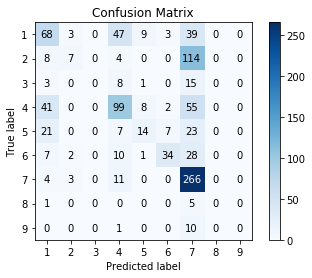

In [32]:
evaluate_features(X, y)
#0.5

### LGM GridSearch

In [34]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100,1000], 
             'penalty':['l1','l2'],
              'tol':[0.001, 0.01, 0.1, 1, 10, 100],
             }

clf = LogisticRegression()
gs_clf(clf, X, y, **param_grid)


Log loss: 1.2407007963499177
Accuracy: 0.544994944388271
{'C': 10, 'penalty': 'l2', 'tol': 0.001}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.6s finished


### RandomForest

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


Log loss: 1.3968278043480455
Accuracy: 0.537917087967644


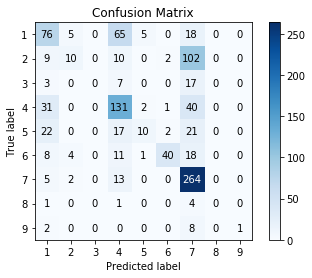

In [35]:
evaluate_features(X, y, 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))
#0.536

### RandomForest + GridSearch

In [36]:
# RF + GS
#X = truncated_tfidf
#X = tfidf

param_grid = {'n_estimators' : [100],
              'max_depth':[5, 10, 15, 20]         
             }

clf = RandomForestClassifier()
gs_clf(clf, X, y, **param_grid)
#0.57

Log loss: 1.4187887032640991
Accuracy: 0.5611729019211324
{'max_depth': 20, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


### SVC

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Log loss: 1.2592102482236833
Accuracy: 0.5278058645096056


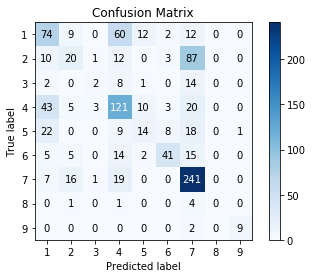

In [38]:
from sklearn.svm import SVC
evaluate_features(X, y , 
                  SVC(kernel='linear', probability=True))
# 0.536

### SVC + GC

In [40]:
X = truncated_tfidf
param_grid = {'C': [10]}

clf = SVC( probability=True)
gs_clf(clf, X, y, **param_grid)


Log loss: 1.2884919277933442
Accuracy: 0.5187057633973711
{'C': 10}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


### MORE Modeling Methods